In [1]:
#import modules
import math
import random
import numpy as np
from numpy.random import randint
from numpy import exp, pi
from numpy import linalg as LA
from numpy.fft import fft2, ifft2, fftshift
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=True)
import cv2
from PIL import Image
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import copy

#import files
import sys
sys.path.append('..')
from utils import matrix as mt
from utils import Likelihood
from utils import message_passing as mp
from utils import PtychoEP
from utils import ptycho_legacy
from utils import test
from utils import config
from utils import engines_legacy
from utils import error

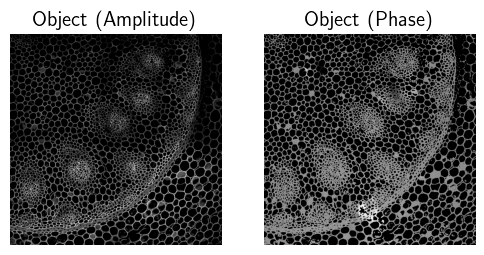

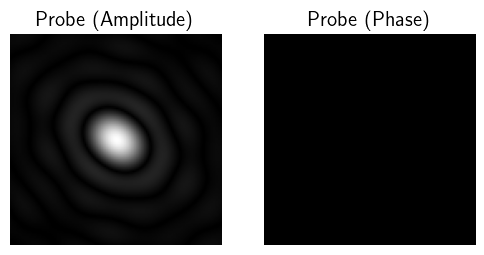

In [2]:
#load pbject image
path_obj_abs = "../data/lily.png"
path_obj_phase = "../data/moon.png"
obj = test.load_complex_image(path_obj_abs, path_obj_phase)

#load probe
probe_abs = np.array(Image.open("../data/probe.png"), dtype = "float")/256
prb = probe_abs + 1j * np.zeros_like(probe_abs)

#showimages
test.show_complex_image(obj, "Object")
test.show_complex_image(prb, "Probe")

c:\Users\ndhaj\Desktop\TCI\PtychoEP\tutorial\..\utils\ptycho_legacy.py:49: RuntimeWarning: invalid value encountered in log10
  ax[l].imshow(np.log10(fftshift(self.diffs[l-1])), cmap = "jet")


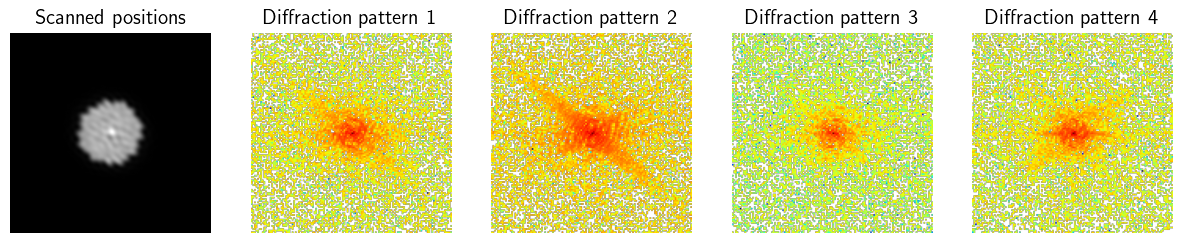

SNR =  18.256391759916042
Samping ratio =  69.32092236090544
Number of scans =  100


In [7]:
np.random.seed(3)
scan_positions = []
c = 8
for i in range(100):
    x, y = int(256 + c * np.sqrt(i) * np.cos(i*2.399967))  , int(256 + c * np.sqrt(i) * np.sin(i*2.399967)) 
    if x - 32 >= 0 and x + 32 <= 512:
        if y - 32 >= 0 and y + 32 <= 512:
            scan_positions.append([x,y])
#scan_positions.extend([[246, 246],[266, 266],[246,266],[266,246]])
#sorting
scan_positions = np.array(scan_positions)
distance = []
for i, scan_pos in enumerate(scan_positions):
    distance.append((256 - scan_pos[0])**2 + (256- scan_pos[1])**2)
distance = np.array(distance)
scan_positions = scan_positions[np.argsort(distance)]

#noise =  0.002099 #sparse image, snr = 30dB
#noise =  0.0275
noise = 0.00669
#create Ptycho object 
ptycho_data = ptycho_legacy.Ptycho(obj, prb, scan_positions, noise)
ptycho_data.show()

#calculate SNR
total = 0
for diff in ptycho_data.diffs:
    total += np.mean(diff**2)
total /= len(scan_positions)
print("SNR = ",10 * np.log10(total/noise**2))
print("Samping ratio = ", ptycho_data.sampling_ratio)
print("Number of scans = ", len(ptycho_data.scan_pos))

### PIE

In [8]:
#make config
alpha = 0.1
object_init = mt.complex_gaussian_matrix(512, 1)
probe = ptycho_data.prb
num_iter = 100 #maximum iteration number
config_PIE = config.config_PIE(alpha, object_init, probe, num_iter)
"""
#run PIE
obj_PIE, error_PIE = engines_legacy.PIE(ptycho_data, config_PIE)

#show ePIE reconstruction
test.show_complex_image(obj_PIE, "Object")
"""

'\n#run PIE\nobj_PIE, error_PIE = engines_legacy.PIE(ptycho_data, config_PIE)\n\n#show ePIE reconstruction\ntest.show_complex_image(obj_PIE, "Object")\n'

In [9]:
%prun  engines_legacy.PIE(ptycho_data, config_PIE)

         1260212 function calls in 12.864 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    60000    4.282    0.000    4.308    0.000 _pocketfft.py:51(_raw_fft)
    10000    3.412    0.000    9.168    0.001 projector.py:9(Fourier_projector)
    10000    2.539    0.000    2.541    0.000 _function_base_impl.py:1649(angle)
        1    1.999    1.999   12.864   12.864 engines_legacy.py:13(PIE)
    30000    0.092    0.000    0.257    0.000 _pocketfft.py:698(_cook_nd_args)
    10000    0.085    0.000    0.085    0.000 {method 'conj' of 'numpy.ndarray' objects}
    30000    0.085    0.000    4.701    0.000 _pocketfft.py:735(_raw_fftnd)
    30000    0.050    0.000    0.093    0.000 fromnumeric.py:41(_wrapit)
    10001    0.046    0.000    0.046    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    30000    0.031    0.000    0.127    0.000 fromnumeric.py:51(_wrapfunc)
    30000    0.029    0.000    0.029    0.000 {method 'take'

### PtychoEP (with no probe retrieval, prior = $\mathcal{CN}(0,1)$)

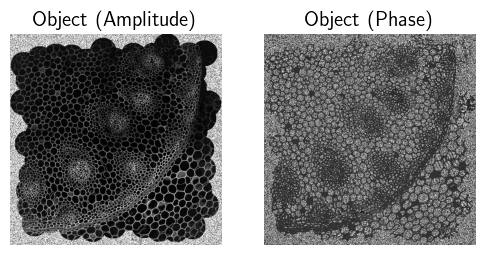

In [6]:
#make config
object_init = mt.complex_gaussian_matrix(512, 1)
probe = ptycho_data.prb
num_iter = 400
num_prb = None
damping = 0.9
config_PtychoEP = config.config_PtychoEP(object_init, probe, num_iter, num_prb, damping)

#run Ptychp-EP
obj_PtychoEP, gamma_PtychoEP, error_PtychoEP = PtychoEP.PtychoEP_Gaussian(ptycho_data, config_PtychoEP)

#show results
test.show_complex_image(obj_PtychoEP, "Object")

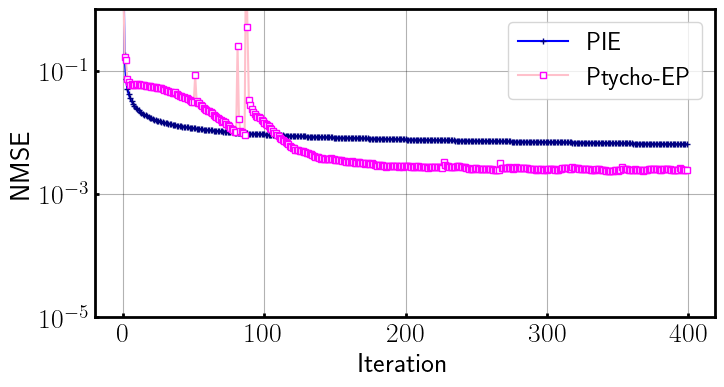

In [7]:
#show result
fig, ax = plt.subplots(1,1, figsize=(8, 4))
plt.tick_params(direction="in", length=3, width=2, labelsize=20)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.plot(error_PIE/total, color = "blue", marker = "+", markeredgecolor = "navy", markerfacecolor = "white", markersize = 5, label = "PIE")
ax.plot(error_PtychoEP/total, color = "pink", marker = "s", markeredgecolor = "magenta", markerfacecolor = "white", markersize = 5, label = "Ptycho-EP")
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("NMSE", fontsize = 20)
ax.set_ylim(1e-5, 1)
ax.set_yscale('log')
ax.legend(fontsize = 18)
ax.grid(which='major',color='black',linestyle='-', alpha = 0.3)
ax.grid(which='minor',color='black',linestyle='--', alpha = 0.3)

np.float64(0.008912722675683136)

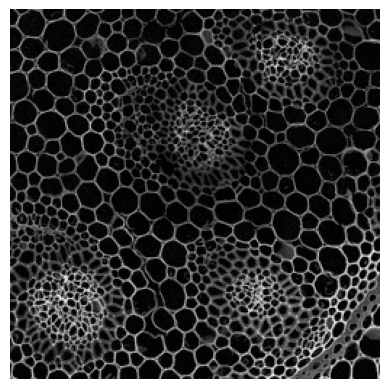

In [9]:
plt.imshow(np.abs(obj_PtychoEP[128:383,128:383]), cmap = "gray", norm = Normalize(0,1))
plt.axis("off")
error.error_metric(obj[128:383,128:383], obj_PtychoEP[128:383,128:383])

np.float64(1.042091479999749)

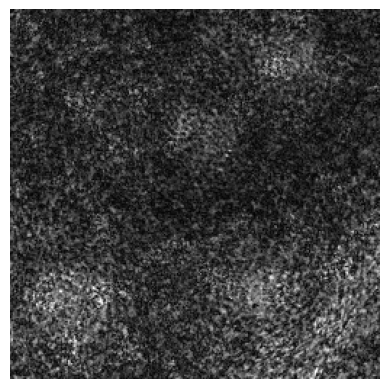

In [ ]:
plt.imshow(np.abs(obj_PIE[128:383,128:383]), cmap = "gray", norm = Normalize(0,1))
plt.axis("off")
error.error_metric(obj[128:383,128:383], obj_PIE[128:383,128:383])

(-0.5, 62.5, 62.5, -0.5)

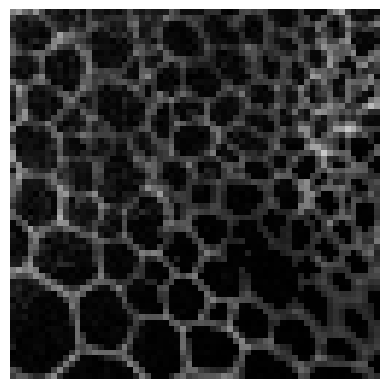

In [ ]:
plt.imshow(np.abs(obj_PtychoEP[192:255,192:255]), cmap = "gray", norm = Normalize(0,1))
plt.axis("off")

(-0.5, 254.5, 254.5, -0.5)

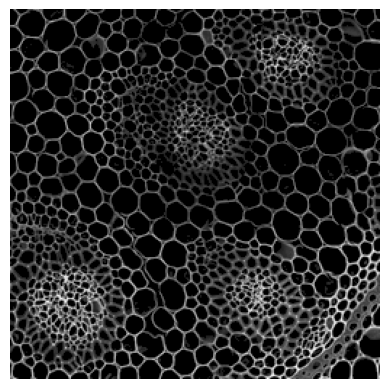

In [ ]:
plt.imshow(np.abs(obj[128:383,128:383]), cmap = "gray", norm = Normalize(0,1))
plt.axis("off")

(-0.5, 62.5, 62.5, -0.5)

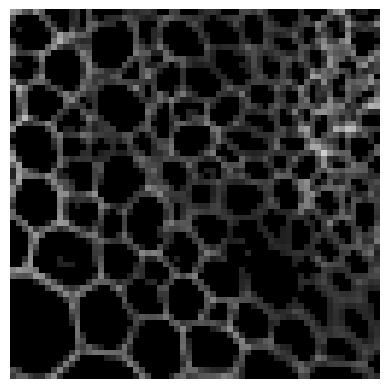

In [ ]:
plt.imshow(np.abs(obj[192:255,192:255]), cmap = "gray", norm = Normalize(0,1))
plt.axis("off")

507904
222877


(-0.5, 254.5, 254.5, -0.5)

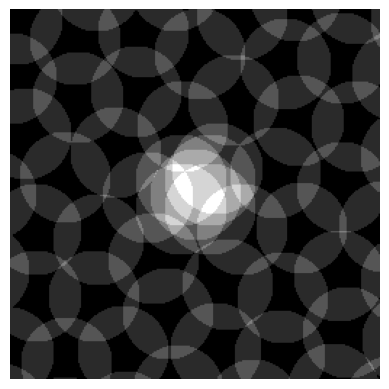

In [ ]:
prb_abs = np.abs(ptycho_data.prb)
scan_img = np.zeros((ptycho_data.obj_len,ptycho_data.obj_len), dtype = float)
for pos in ptycho_data.scan_pos:
    scan_img[pos[0] - ptycho_data.prb_len//2 : pos[0] + ptycho_data.prb_len//2, pos[1] - ptycho_data.prb_len//2 : pos[1] + ptycho_data.prb_len//2] += prb_abs**2
sampling_number = np.sum(scan_img > 0.1 * np.max(scan_img))
print(ptycho_data.prb_len**2 * len(ptycho_data.scan_pos))
print(sampling_number)

plt.style.use('tableau-colorblind10')
plt.imshow(scan_img[128:383,128:383], cmap = "gray")
plt.axis("off")

### Movie

In [ ]:
import imageio

def PtychoEP_Gaussian_GetImage(ptycho_data, config):
    #load ptycho_data
    obj_len = ptycho_data.obj_len
    prb_len = ptycho_data.prb_len
    scan_pos = ptycho_data.scan_pos
    gamma_w = (1/ptycho_data.noise)**2
    diffs = ptycho_data.diffs
    #image list

    #initialize some variables
    O_int = config.object_init
    gamma_int_O = np.ones((obj_len, obj_len))
    P = config.probe_init
    P_intensity = np.abs(P)**2
    gamma_int_Phi = np.ones(len(scan_pos))
    gamma_int_O_hat = np.ones((obj_len, obj_len))
    beta_int_hat = np.zeros_like(O_int)
    Phi_int, Phi_int_ift = [], []
    for j, pos in enumerate(scan_pos):
        O_j = O_int[pos[0] - prb_len//2 : pos[0] + prb_len//2, pos[1] - prb_len//2 : pos[1] + prb_len//2]
        exit_wave_j = P * O_j
        Phi_int_ift.append(exit_wave_j)
        Phi_int.append(fft2(exit_wave_j)/prb_len)
        gamma_int_O_hat[pos[0] - prb_len//2 : pos[0] + prb_len//2, pos[1] - prb_len//2 : pos[1] + prb_len//2] += P_intensity
        beta_int_hat[pos[0] - prb_len//2 : pos[0] + prb_len//2, pos[1] - prb_len//2 : pos[1] + prb_len//2] += P_intensity * O_j
    #main iteration
    for iter in range(config.num_iter):
        for j, pos in enumerate(scan_pos):
            #LLMSE
            O_int_hat_j = beta_int_hat[pos[0] - prb_len//2 : pos[0] + prb_len//2, pos[1] - prb_len//2 : pos[1] + prb_len//2]/gamma_int_O_hat[pos[0] - prb_len//2 : pos[0] + prb_len//2, pos[1] - prb_len//2 : pos[1] + prb_len//2]
            Phi_int_hat_j = fft2(P * O_int_hat_j)/prb_len
            gamma_int_hat_j = 1/np.mean(P_intensity/gamma_int_O_hat[pos[0] - prb_len//2 : pos[0] + prb_len//2, pos[1] - prb_len//2 : pos[1] + prb_len//2])
            #Message Passing
            Phi_ext_j, gamma_ext_Phi_j = mp.Message_Passing(Phi_int[j], gamma_int_Phi[j], Phi_int_hat_j, gamma_int_hat_j)
            #denoising by diffraction pattern
            Phi_ext_j_hat, gamma_ext_Phi_j_hat = Likelihood.PR_output_Likelihood(Phi_ext_j, gamma_ext_Phi_j, diffs[j], gamma_w)
            #Message Passing with damping
            Phi_int_j_raw, gamma_int_Phi_raw = mp.Message_Passing(Phi_ext_j, gamma_ext_Phi_j, Phi_ext_j_hat, gamma_ext_Phi_j_hat)
            Phi_int_j_new, gamma_int_Phi_new = mp.Damping(Phi_int_j_raw, gamma_int_Phi_raw, Phi_int[j], gamma_int_Phi[j], config.damping)
            Phi_int_j_new_ift = ifft2(Phi_int_j_new)*prb_len
            #update beta_int_hat, gamma_o_int_hat, Phi_int, Phi_int_ift, gamma_int_Phi
            gamma_int_O_hat[pos[0] - prb_len//2 : pos[0] + prb_len//2, pos[1] - prb_len//2 : pos[1] + prb_len//2] += (gamma_int_Phi_new - gamma_int_Phi[j]) * P_intensity
            beta_int_hat[pos[0] - prb_len//2 : pos[0] + prb_len//2, pos[1] - prb_len//2 : pos[1] + prb_len//2] += \
                  P.conj() * (gamma_int_Phi_new * Phi_int_j_new_ift - gamma_int_Phi[j] * Phi_int_ift[j])
            gamma_int_Phi[j] = gamma_int_Phi_new
            Phi_int[j] = Phi_int_j_new
            Phi_int_ift[j] = Phi_int_j_new_ift
        #denoising by prior
        O_int_hat = beta_int_hat/gamma_int_O_hat
        O_ext, gamma_ext_O = mp.Message_Passing(O_int, gamma_int_O, O_int_hat, gamma_int_O_hat)
        O_ext_hat, gamma_ext_O_hat = Likelihood.gaussian_complex_input_Likelihood(O_ext, gamma_ext_O)
        O_int_new, gamma_int_O_new = mp.Message_Passing(O_ext, gamma_ext_O, O_ext_hat, gamma_ext_O_hat)
        #update beta_int_hat, gamma_int_O_hat
        gamma_int_O_hat += gamma_int_O_new - gamma_int_O
        beta_int_hat += gamma_int_O_new * O_int_new - gamma_int_O * O_int
        gamma_int_O, O_int = gamma_int_O_new, O_int_new
        if iter % 10 == 0:
            #save precision
            fig, ax = plt.subplots()
            ax.imshow(np.abs(O_int_hat[128:383,128:383]), cmap = "gray", norm = Normalize(vmin = 0, vmax = 1))
            ax.axis("off")
            file_reconstruction = "../movie/reconstruction" + str(iter) + ".png"
            fig.savefig(file_reconstruction, bbox_inches='tight', transparent = True)
            plt.close(fig)
            #save precision
            fig, ax = plt.subplots()
            ax.imshow(np.abs(np.log10(gamma_int_O_hat[128:383,128:383])), cmap = "jet", norm = Normalize(vmin = 1, vmax = 4.5))
            ax.axis("off")
            file_reconstruction = "../movie/precision" + str(iter) + ".png"
            fig.savefig(file_reconstruction, bbox_inches='tight', transparent = True)
            plt.close(fig)
    return O_int_hat, gamma_int_O_hat

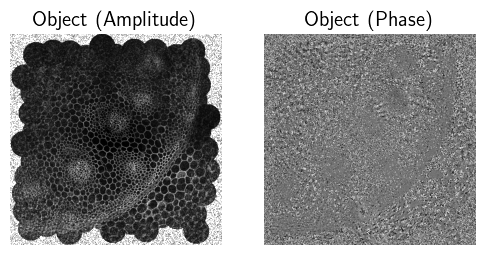

In [ ]:
#make config
object_init =  mt.complex_gaussian_matrix(512, 1)
probe = ptycho_data.prb
num_iter = 401
num_prb = None
damping = 0.9
config_PtychoEP = config.config_PtychoEP(object_init, probe, num_iter, num_prb, damping)

#run Ptychp-EP
obj_PtychoEP, gamma_PtychoEP = PtychoEP_Gaussian_GetImage(ptycho_data, config_PtychoEP)

#show results
test.show_complex_image(obj_PtychoEP, "Object")

In [ ]:
"""
#画像を入れるリスト
pictures=[]
#画像を入れる
for i in range(40):
    pic_name="../movie/precision" + str(i*10) + ".png"
    img = Image.open(pic_name)
    pictures.append(img)
#gifアニメを出力する
pictures[0].save('../movie/precision.gif',save_all=True, append_images=pictures[1:],
optimize=True, duration=500, loop=0)

SyntaxError: incomplete input (2058603369.py, line 1)

In [ ]:
"""
#画像を入れるリスト
pictures=[]
#画像を入れる
for i in range(40):
    pic_name="../movie/reconstruction" + str(i*10) + ".png"
    img = Image.open(pic_name)
    pictures.append(img)
#gifアニメを出力する
pictures[0].save('../movie/reconstruction.gif',save_all=True, append_images=pictures[1:],
optimize=True, duration=500, loop=0)